In [73]:
from jupyter_dash import JupyterDash
import dash
from dash.dependencies import Input, Output, State
import dash_bootstrap_components as dbc
import dash_html_components as html
import dash_core_components as dcc
from dash_slicer import VolumeSlicer
import dash_table
import plotly.graph_objs as go
import numpy as np
from nilearn import image
from skimage import draw, filters, exposure, measure
from scipy import ndimage
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import skimage as sk 
from skimage import data, io, morphology, img_as_ubyte, segmentation
from skimage.util import compare_images
from skimage.morphology import erosion, dilation, disk, square, closing, rectangle, diameter_closing
import skimage.filters as flt
from skimage.filters import median, threshold_local, threshold_otsu, roberts, sobel, gaussian, rank
from skimage.measure import label, regionprops
from skimage.color import label2rgb, rgb2gray
from skimage.segmentation import active_contour, chan_vese
from skimage.draw import polygon
from skimage.transform import warp
from skimage.registration import optical_flow_tvl1
from scipy.signal.signaltools import wiener
from scipy import ndimage
import cv2 as cv
import numpy as np
from PIL import Image
import json
import re
import time
from skimage import io
import os

C:\Users\María Regalado\AppData\Local\Temp\ipykernel_18636\359679115.py:30: DeprecationWarning: Please use `wiener` from the `scipy.signal` namespace, the `scipy.signal.signaltools` namespace is deprecated.
  from scipy.signal.signaltools import wiener


**Pasos que me gustaría impplementar dentro de la Aplicación**

* **1.** Crear un botón al lado de run segmentation que se llame run segmentation 2
* **2.** Cargar imagen
* **3.** Mejorar el contraste de la imagen con sk.exposure.adjust_sigmoid
* **4.** Seleccionar el recuadro dónde se aplicará el método de segmentación a partir de la segmentación manual de las doctoras. (Esta parte sería igual que en el método de  segmentación actual)
* **5.** Aplicar el método de segmentación Morphological ACWE al recuadro.
* **6.** Mostrar únicamente el contorno con el área más grande.

**IMPORTANTE** En el método de Run segmentation 2 no quiero aplicar antes del Morphological ACWE ni Threshold ni Máscaras, ja que la función no las necesita y da mejores resultados sin usar estos métodos. 

( También me gustaría implementar el sk.exposure.adjust_sigmoid(img, 0.4, 10) en el método de David antes del Threshold, porque he añadido imágenes a la App anteriormente procesadas con ese tipo de filtro y se han observado mejorías en los resultados ).

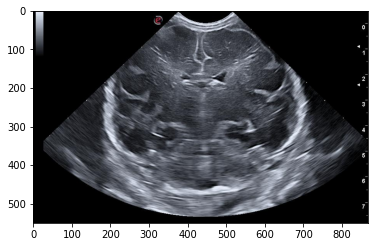

In [74]:
#2. Cargar imagen
image_test = Image.open('./Data_Base_update/BM091/BM091_29/BM091_29_c4.jpg')
# image_test.show()
plt.imshow(image_test)

In [75]:
filename = './Data_Base_update/BM091/BM091_29/BM091_29_c4.jpg'
image_test_2 = io.imread(filename, as_gray=True)

In [76]:
# seg_manual = 'M453.65996620471674,169.7884089338814L449.87482480909557,175.46612102731314L408.23826945726296,188.71411591198716L389.3125624791572,188.71411591198716L389.3125624791572,173.57355032950258L404.4531280616418,158.43298474701797L406.3456987594524,95.97815171926904L415.80855224850524,75.15987404335273L442.3045420178533,61.9118791586787L449.87482480909557,63.80444985648928L449.87482480909557,88.40786892802674L457.4451076003379,99.76329311489019L489.6188094631176,122.47414148861708L489.6188094631176,133.82956567548052L465.0153903915802,137.61470707110166L459.33767829814843,150.8627019557757Z'
# seg_manual = 'M656.1650308704482,243.5986661484938L654.2724601726376,236.02838335725153L637.2393238923424,224.67295917038808L637.2393238923424,239.81352475287267L620.2061876120472,251.1689489397361L595.6027685405097,251.1689489397361L593.7101978426992,234.13581265944094L582.3547736558357,228.45810056600922L574.7844908645934,224.67295917038808L565.3216373755406,203.85468149447175L582.3547736558357,201.9621107966612L586.1399150514569,192.4992573076083L605.0656220295626,200.0695400988506L631.5616117989107,184.92897451636603L650.4873187770164,175.46612102731314L661.8427429638799,179.2512624229343L673.1981671507433,220.88781777476692L675.0907378485539,232.24324196163036Z'
seg_manual = 'M502.9724488870768,325.5622090605451L505.5769807109501,316.88043631430054L508.61560117213577,316.4463476769883L519.4678171049414,306.89639765611923L524.242792115376,300.819156733748L534.2268307735573,299.0828021844991L538.1336285093673,302.12142264568473L542.4745148824896,302.12142264568473L545.9472239809875,300.3850680964358L545.9472239809875,301.25324537106025L541.1722489705529,304.29186583224583L528.5836784884983,309.0668408426804L529.4518557631228,310.8031953919293L533.792742136245,316.4463476769883L535.0950080481817,318.1827022262372L537.6995398720551,318.61679086354945L547.6835785302364,318.61679086354945L561.1403262869155,316.01225903967605L575.4652513182191,310.8031953919293L578.9379604167169,310.36910675461706L588.0538218002738,306.02822038149475L587.1856445256493,301.6873340083725L581.1084036032781,296.0441817233135L572.4266308570335,286.9283203397567L567.6516558465989,279.5488135054488L561.1403262869155,274.33974985770203L552.4585535406709,274.33974985770203L537.265451234743,280.4169907800732L532.9245648616206,282.58743396663436L516.8632852810681,283.0215226039466L505.1428920736379,281.71925669200994L492.120232954271,283.45561124125885L475.1907760990941,287.3624089770689L472.15215563790844,293.4396498994401L470.4158010886595,298.21462490987466L464.77264880360053,304.29186583224583L459.99767379316603,313.8418158531149L458.6954078812293,320.7872340501106L458.6954078812293,327.29856360979403L458.6954078812293,328.1667408844185Z'
coor = seg_manual[1:-1].split('L')
coordenadas_grooves_manual = coor
coordinates_segmentation = coor

coor

['502.9724488870768,325.5622090605451',
 '505.5769807109501,316.88043631430054',
 '508.61560117213577,316.4463476769883',
 '519.4678171049414,306.89639765611923',
 '524.242792115376,300.819156733748',
 '534.2268307735573,299.0828021844991',
 '538.1336285093673,302.12142264568473',
 '542.4745148824896,302.12142264568473',
 '545.9472239809875,300.3850680964358',
 '545.9472239809875,301.25324537106025',
 '541.1722489705529,304.29186583224583',
 '528.5836784884983,309.0668408426804',
 '529.4518557631228,310.8031953919293',
 '533.792742136245,316.4463476769883',
 '535.0950080481817,318.1827022262372',
 '537.6995398720551,318.61679086354945',
 '547.6835785302364,318.61679086354945',
 '561.1403262869155,316.01225903967605',
 '575.4652513182191,310.8031953919293',
 '578.9379604167169,310.36910675461706',
 '588.0538218002738,306.02822038149475',
 '587.1856445256493,301.6873340083725',
 '581.1084036032781,296.0441817233135',
 '572.4266308570335,286.9283203397567',
 '567.6516558465989,279.5488135

In [77]:
range(len(coordinates_segmentation))

range(0, 40)

In [78]:
# Points coordinates of each annotation
x_coordinates_each_segmentation = []
y_coordinates_each_segmentation = []

i = 0 # en este caso para que funcione y se comenta la siguiente linea ya que solo se ha segmentado un surco
#for i in range(len(coordenadas_grooves_manual)):

# For each coordinate of the annotation shape contour
x_contour = []
y_contour = []
for iii in range(len(coordinates_segmentation)):

    # Point coordinates
    x_i, y_i = coordinates_segmentation[iii].split(",")
    x_contour.append(float(x_i))
    y_contour.append(float(y_i))

    # Save the initial point
    if (iii==0):
        x_close = float(x_i)
        y_close = float(y_i)

    # Add initial point to close the shape
    if (iii==(len(coordinates_segmentation[i])-1)):
        x_contour.append(x_close)
        y_contour.append(y_close)



In [79]:
# Coordinates of all the points of the shape
x = x_contour
y = y_contour

# Take region of the sulcre (bounding box)
x_max, x_min = np.uint(np.max(x)), np.uint(np.min(x))
y_max, y_min = np.uint(np.max(y)), np.uint(np.min(y))

In [80]:
def image_show(image, nrows=1, ncols=1, cmap='gray'):
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 14))
    ax.imshow(image, cmap='gray')
    ax.axis('off')
    return fig, ax

In [81]:
x

[502.9724488870768,
 505.5769807109501,
 508.61560117213577,
 519.4678171049414,
 524.242792115376,
 534.2268307735573,
 538.1336285093673,
 542.4745148824896,
 545.9472239809875,
 545.9472239809875,
 541.1722489705529,
 528.5836784884983,
 529.4518557631228,
 533.792742136245,
 535.0950080481817,
 537.6995398720551,
 547.6835785302364,
 561.1403262869155,
 575.4652513182191,
 578.9379604167169,
 588.0538218002738,
 587.1856445256493,
 581.1084036032781,
 572.4266308570335,
 567.6516558465989,
 561.1403262869155,
 552.4585535406709,
 537.265451234743,
 532.9245648616206,
 516.8632852810681,
 505.1428920736379,
 492.120232954271,
 475.1907760990941,
 472.15215563790844,
 470.4158010886595,
 502.9724488870768,
 464.77264880360053,
 459.99767379316603,
 458.6954078812293,
 458.6954078812293,
 458.6954078812293]

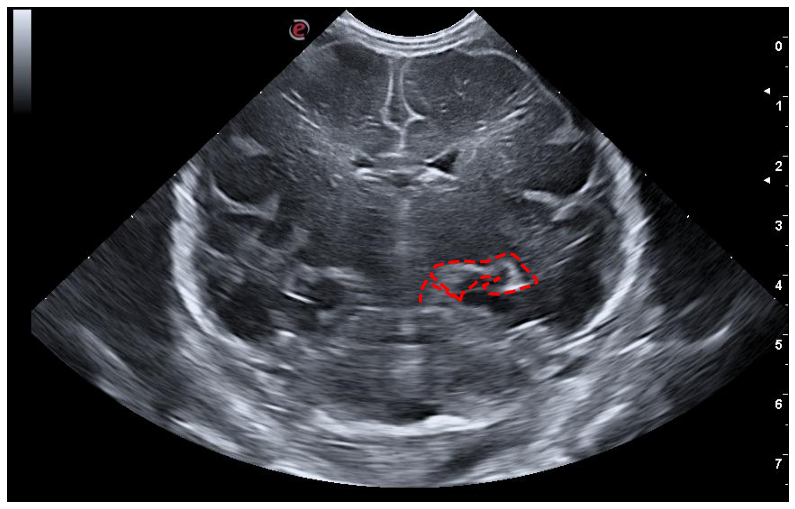

In [82]:
ig, ax = image_show(image_test)
ax.plot(x, y, '--r', lw=3)

In [83]:
np.column_stack((x,y))

array([[502.97244889, 325.56220906],
       [505.57698071, 316.88043631],
       [508.61560117, 316.44634768],
       [519.4678171 , 306.89639766],
       [524.24279212, 300.81915673],
       [534.22683077, 299.08280218],
       [538.13362851, 302.12142265],
       [542.47451488, 302.12142265],
       [545.94722398, 300.3850681 ],
       [545.94722398, 301.25324537],
       [541.17224897, 304.29186583],
       [528.58367849, 309.06684084],
       [529.45185576, 310.80319539],
       [533.79274214, 316.44634768],
       [535.09500805, 318.18270223],
       [537.69953987, 318.61679086],
       [547.68357853, 318.61679086],
       [561.14032629, 316.01225904],
       [575.46525132, 310.80319539],
       [578.93796042, 310.36910675],
       [588.0538218 , 306.02822038],
       [587.18564453, 301.68733401],
       [581.1084036 , 296.04418172],
       [572.42663086, 286.92832034],
       [567.65165585, 279.54881351],
       [561.14032629, 274.33974986],
       [552.45855354, 274.33974986],
 

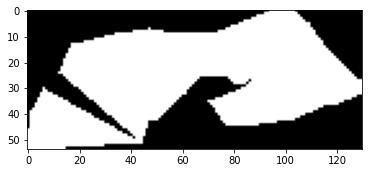

In [84]:
# Mask polygon
mask_polygon = np.zeros(image_test_2.shape)
xf, yf = np.uint(x), np.uint(y)
mask_polygon[yf,xf] = 1
xfilled, yfilled = polygon(xf, yf)
mask_polygon[yfilled,xfilled] = 1

mask_polygon_cut = mask_polygon[y_min:y_max, x_min:x_max]
plt.imshow(mask_polygon_cut, cmap = 'gray')

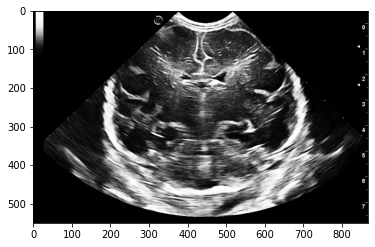

In [85]:
#3. Mejorar el contraste de la imagen con sk.exposure.adjust_sigmoid
IG4 = sk.color.rgb2gray(image_test)
IA4=sk.exposure.adjust_sigmoid(IG4, 0.4, 10)
plt.imshow(IA4, cmap = 'gray')

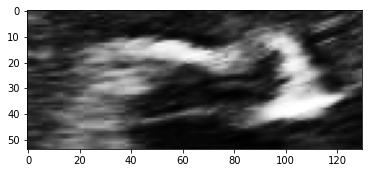

In [86]:
#4. Seleccionar el recuadro dónde se aplicará el metodo de segmentación a partir de la segmentación manual de las doctoras.
#En esta hoja lo selecciono manualmente
IA4_cut = IA4[y_min:y_max, x_min:x_max]
IA4_cut = (IA4_cut-np.min(IA4_cut))/(np.max(IA4_cut)-np.min(IA4_cut))
#IA4_cut = IA4[100:200,250:350]
plt.imshow(IA4_cut, cmap = 'gray')

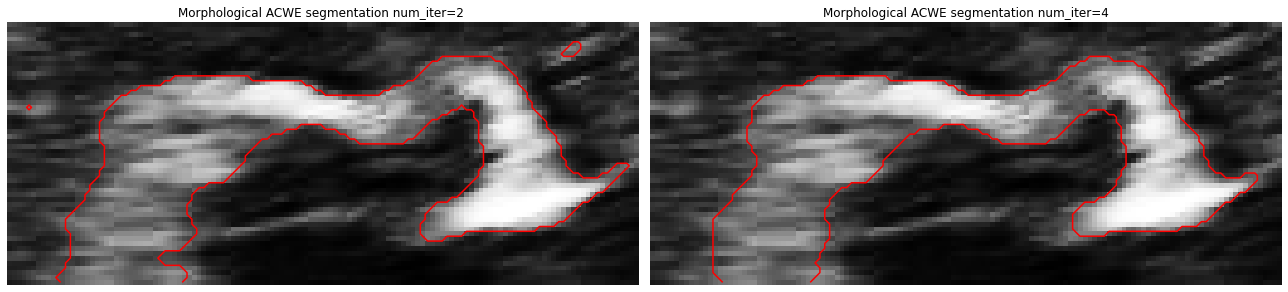

In [87]:
#5. Aplicar el método de segmentación Morphological ACWE al recuadro.
#En este caso se muestran dos imagenes pq una es de 2 iteraciones del método y la otra de 4, tengo que hablar con Christian para ver cual decidimos poner.

import numpy as np
import matplotlib.pyplot as plt
from skimage import data, img_as_float
from skimage.segmentation import (morphological_chan_vese,
                                  morphological_geodesic_active_contour,
                                  inverse_gaussian_gradient,
                                  checkerboard_level_set)

def store_evolution_in(lst):
    """Returns a callback function to store the evolution of the level sets in
    the given list.
    """

    def _store(x):
        lst.append(np.copy(x))

    return _store

# Morphological ACWE
image = IA4_cut
# Initial level set
init_ls = checkerboard_level_set(image.shape, 2)
init_ls2 = checkerboard_level_set(image.shape,2)
# List with intermediate results for plotting the evolution
evolution = []
callback = store_evolution_in(evolution)
ls = morphological_chan_vese(image, num_iter=2, init_level_set=init_ls,
                             smoothing=3, iter_callback=callback)
ls2 = morphological_chan_vese(image, num_iter=4, init_level_set=init_ls2,
                             smoothing=3, iter_callback=callback)

fig, axes = plt.subplots(1,2, figsize=(18, 18))
ax = axes.flatten()

ax[0].imshow(IA4_cut, cmap="gray")
ax[0].set_axis_off()
ax[0].contour(ls, [0.5], colors='r')
ax[0].set_title("Morphological ACWE segmentation num_iter=2 ", fontsize=12)

ax[1].imshow(IA4_cut, cmap="gray")
ax[1].set_axis_off()
ax[1].contour(ls2, [0.5], colors='r')
ax[1].set_title("Morphological ACWE segmentation num_iter=4", fontsize=12)

fig.tight_layout()
plt.show()

In [88]:
#6. Mostrar únicamente el contorno con el área más grande
#Esta parte no sé cómo realizarla para que en la aplicación solo salga la segmentación con el contorno más grande.

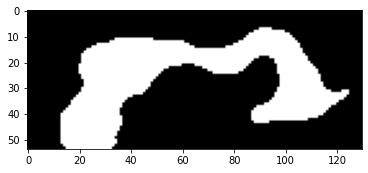

In [89]:
plt.imshow(ls2,cmap = 'gray')

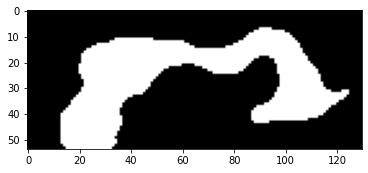

In [90]:
# Se busca el porcentage de los bits de 1, que deberian de ser las estructuras y surcos y 0, el fondo. Si la cantidad de pixeles en 1 es mayor, es erroneo
# y se ha de invertir.
# se suma todos los bits y se busca el porcentage de pixeles en 1 en la imagen
sum_pixel = np.sum(ls2)
img_test_pixel = ls2.shape[0]*ls2.shape[1]

ones_percentage = sum_pixel / img_test_pixel

#se invierte si la cantidad de 1s es mayor que de 0s
if ones_percentage > 0.5:
    ls2 = 1 - ls2

plt.imshow(ls2,cmap = 'gray')

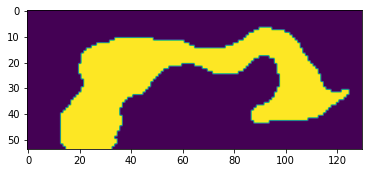

In [91]:
 # Label image regions:
label_image, nregions = label(ls2,return_num=True)
ind_regions = np.arange(1,nregions+1)
plt.imshow(label_image)

In [92]:
props = regionprops(label_image)
len(props)

1

In [93]:
# Area and centroid of each region
area = []
Centroid_list = []
for p in props:
    area.append(p.area)

    y0, x0 = p.centroid
    y0_norm = np.uint(y0)
    x0_norm = np.uint(x0)
    Centroid_list.append([x0_norm, y0_norm])

In [94]:
# Mask polygon
mask_polygon = np.zeros(image_test_2.shape)
xf, yf = np.uint(x), np.uint(y)
mask_polygon[yf,xf] = 1
xfilled, yfilled = polygon(xf, yf)
mask_polygon[yfilled,xfilled] = 1

mask_polygon_cut = mask_polygon[y_min:y_max, x_min:x_max]

Centroides_goods = []
area_goods =[]

good_regions = np.zeros(len(Centroid_list))
# Area and coordinates of the regions inside the mask
for iv in range(len(Centroid_list)):
    if (mask_polygon_cut[Centroid_list[iv][1], Centroid_list[iv][0]] == 1):
        Centroides_goods.append(Centroid_list[iv])
        area_goods.append(area[iv])
        good_regions[iv] = 1

ind_good = np.where((good_regions == 1))
ind_gregions = np.squeeze(np.array(ind_good)+1)

ind_bad = np.where((good_regions == 0))
ind_bregions = np.array(ind_bad)+1

# Biggest component (the one with the biggest area)
index_list_biggest = np.argmax(area_goods)
index_comp_biggest = ind_gregions[index_list_biggest]

# Delete out and small regions
label_image[label_image!=index_comp_biggest] = 0

plt.imshow(label_image, cmap = 'gray')

IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed